In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import boston_housing
from sklearn import datasets
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# -1. Matrices, Gradients, Hessians

Given the function $f(x1, x2) = (1 - x1)^2 + 5 (x2 - x1^2)^2$, compute:

### a) Gradient $\nabla f(1, 1)$
### $\delta f/dx_1 = 2(-1)(1-x_1)+5(2)(-2x_1)(x_2-x_1^2) = -2 + 2x_1 - 20x_1x_2+20x_1^3$
### $\delta f/dx_2 = 5(2)(1)(x_2-x_1^2) = 10x_2-10x_1^2$
### $\nabla f(x_1, x_2) =
\begin{pmatrix}
-2 + 2x_1 - 20x_1x_2+20x_1^3  & 10x_2-10x_1^2
\end{pmatrix}$
### $\nabla f(1, 1) =
\begin{pmatrix}
-2 + 2 - 20 + 20 & 10 - 10
\end{pmatrix} =
\begin{pmatrix}
0 & 0
\end{pmatrix}$

### b) Hessian $\nabla^2 f(1,1)$
### $\delta^2 f/dx_1^2 = 2 - 20x_2 + 60 x_1^2$
### $\delta^2 f/dx_2^2 = 10$
### $\delta^2 f/dx_1dx_2 = \delta^2 f/dx_2dx_1 = -20x_1$
### $\nabla^2 f(x_1, x_2) =
\begin{pmatrix}
  2 - 20x_2 + 60 x_1^2 & -20x_1 \\
  -20x_1 & 10
\end{pmatrix}$
### $\nabla^2 f(1, 1) =
\begin{pmatrix}
  42 & -20 \\
  -20 & 10
\end{pmatrix}$

### c) Is the hessian positive definite? Why? $p^T H p > 0$

### Let p = $
\begin{pmatrix}
  1 \\ 1
\end{pmatrix}
$. $p^THp =
\begin{pmatrix}
  1 & 1
\end{pmatrix}
\begin{pmatrix}
  42 & -20 \\
  -20 & 10
\end{pmatrix}
\begin{pmatrix}
  1 \\ 1
\end{pmatrix} =
\begin{pmatrix}
  22 & -10
\end{pmatrix}
\begin{pmatrix}
  1 \\ 1
\end{pmatrix} = 12
$
### Since 12 > 0, the Hessian is positive definite at point (1,1).

# 0. Implementing 'Package' Supporting Functions

In [ ]:
def relu(x):
  """Computes relu of function."""
  return x * (x >= 0)


def sigmoid(x):
  """Computes sigmoid of function."""
  return 1 / (1 + np.exp(-x))

def linear(x):
  """Return linear function of itself."""
  return x

def d_linear(x):
    return np.ones_like(x)

def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

def d_relu(x):
    return (x >= 0).astype(np.float32)

activations = {
    "linear": linear,
    "relu": relu,
    "sigmoid": sigmoid
}

d_activations = {
    "linear": d_linear,
    "relu": d_relu,
    "sigmoid": d_sigmoid
}

In [ ]:
def initialize_weights(shapes, outputs):
    """Initializes weights of model according to shape.
     Args:
       shapes = [784, 300, 10]
       outputs = ["linear", "sigmoid"]

     returns:
       model with uniform random weights [-1,+1], zero bias and output function
       [
        [random(784, 300), zeros(300), "linear"]
        [random(300, 10), zeros(10), "sigmoid"]
       ]

    """
    # do your code here
    model = []
    for i in range(len(shapes)-1):
      layer = [np.random.uniform(-1, 1, (shapes[i], shapes[i+1])), np.zeros(shapes[i+1]), outputs[i]]
      model.append(layer)
    return model

model = initialize_weights([4, 10, 3], ['sigmoid', 'sigmoid'])

model
#[[w1, b1, 'sigmoid'], [w2, b2, 'sigmoid']]

[[array([[ 0.2700784 , -0.40196043,  0.43104387, -0.34199981, -0.57896222,
           0.77611834,  0.9542272 ,  0.8016223 ,  0.14914703,  0.77277493],
         [-0.3549497 ,  0.72592129,  0.49940213, -0.96564659, -0.22805449,
           0.67480839,  0.2842048 ,  0.7867564 , -0.86116032, -0.67293558],
         [ 0.529237  , -0.15420237, -0.98867808, -0.86512342, -0.23594624,
           0.36415011,  0.49552088,  0.2689968 , -0.58252994,  0.40781189],
         [-0.18788703,  0.43528727,  0.67647181, -0.04490848,  0.56671733,
          -0.73808008, -0.40280962, -0.1074882 ,  0.25226591, -0.86840408]]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'sigmoid'],
 [array([[ 0.26502136, -0.05080583, -0.93305873],
         [-0.43975319, -0.42021082,  0.32356652],
         [ 0.33814229,  0.42189843,  0.24486083],
         [-0.83131878, -0.18437547, -0.71911435],
         [ 0.88566271, -0.91217206, -0.72413004],
         [ 0.84558336, -0.21859929, -0.70845534],
         [-0.81273424, -0.780

In [ ]:
def forward(x, model):
    """Performs forward pass of training step.

     Args:
       x: input tensor of shape (B, N0)
       model: list of model weights (see initialize weights)
     Returns:
       List containing dictionary { "y": y, "z": z } for each layer of network.
       [{"y": y1, "z": z1}, {"y": y2, "z": z2}]
    """
    result = []
    y = x
    for layer in model:
      # layer = [ w[i], b[i], 'relu']
      z = np.dot(y, layer[0]) + layer[1]  # (B,N1) + (N1,N2)
      y = activations[layer[2]](z)
      result.append({'y': y, 'z': z})

    return result

In [ ]:
def predict(x, model):
  """Predicts the output of a model.

     Args:
       x: input tensor of shape (B, Ni)
       model: list of model weights (see initialize weights)
     Returns:
       Prediction of model, with the same shape as the labeled data (B, No).
  """
  fwd = forward(x, model)
  return fwd[-1]["y"]

In [ ]:
def backward(y, x, model, loss):
  """Computes backward step of training.
     Args:
       y: labeled data of size (B, No)
       x: input tensor of shape (B, Ni)
       model: list of model weights (see initialize weights)
       loss: one of ("mse", "binary_crossentropy")
     Returns:
       tuple with loss evaluation of (y, predict(x)) and list of dictionary
       containing { "dw": dw, "db": db } for each layer of network. Remember
       that shape of dw for each layer should be equal to shape of weight for
       the same layer.
       [{"dw": dw1, "db": db1}, {"dw": dw2, "db": db2}]
  """
  # add backward here
  p = predict(x, model)
  fwd = forward(x, model)

  if loss == "mse":
    loss_evaluation = mse(y, p)

    N = y.shape[0]
    deriv_loss = -2/N * (y - p)

  elif loss == "binary_crossentropy":
    loss_evaluation = binary_crossentropy(y, p)

    deriv_loss = -(y/p - (1-y)/(1-p))

  #print("back")
  deriv_y = deriv_loss
  dweights = []
  for i in range(len(model) - 1, -1, -1):
    layer = model[i]

    if i == 0:
      output_prev = x
    else:
      output_prev = fwd[i-1]["y"]

    # gradient of activation function

    # z = W * y + b
    # dl/dy is just the derivation of the loss function
    # dy/dz = derivation of the activation function
    # deriv_z = dl / dz = dl/dy * dy/dz
    z = fwd[i]['z']
    deriv_activation = d_activations[layer[2]](z)
    deriv_z = deriv_y * deriv_activation


    # gradients of the weights and biases

    # dl / dw = output_prev transposed x dl/dz
    dw = np.dot(output_prev.T, deriv_z)

    # dl/db = sum(dl/dz)
    db = np.sum(deriv_z, axis=0, keepdims=True)


    # repeat backpropagation with new dy
    deriv_y = np.dot(deriv_z, layer[0].T)

    dweights.append({"dw":dw, "db":db})

  dweights.reverse()

  return loss_evaluation, dweights

In [ ]:
def update(weights, dweights, alpha):
  """Gradient descent for weights and biases."""
  for i in range(len(weights)):
    weights[i][0] += - alpha * dweights[i]["dw"]
    weights[i][1] += - alpha * dweights[i]["db"].reshape(weights[i][1].shape)

In [ ]:
def mse(y, p):
  """Computes Mean-Square Error between y and p.
     Args:
       y: labeled data of size (B, No)
       p: predicted label of size (B, No)
     Returns:
       MSE of y-p
  """
  #assert p.shape == y.shape
  return np.mean((y - p)**2)

def binary_crossentropy(y, p):
  """Computes binary crossentropy between y and p.
     Args:
       y: labeled data of size (B, No)
       p: predicted label of size (B, No)
     Returns:
       BCE of (y, p) = mean(sum(y log(p) + (1-y) log(1-p)))
  """
  return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))


# 1. Creating and Training Linear Regression on Boston Dataset

In [ ]:
def standardize(x):
    # standardize = x - mean(x) / std(x)
    return (x - np.mean(x, axis = 0))/np.std(x, axis = 0, keepdims=True)

def load_data():
  (x_train, y_train), (x_test, y_test) = boston_housing.load_data()

  # condition data to be in a format you need to use
  x_train = standardize(x_train)
  x_test = standardize(x_test)
  y_train = standardize(y_train).reshape(-1, 1)
  y_test = standardize(y_test).reshape(-1, 1)

  return (x_train, y_train), (x_test, y_test)

0 4.360300334402715
1 4.197453335569373
2 4.042706564267939
3 3.895475318276519
4 3.7552492154351174
5 3.621578029119058
6 3.494060646549206
7 3.3723364350708556
8 3.2560784666373834
9 3.1449881776277744
10 3.0387911386567534
11 2.937233684001296
12 2.8400802078921736
13 2.7471109792185358
14 2.658120360252153
15 2.5729153411865653
16 2.491314322426519
17 2.4131460920545886
18 2.338248957820532
19 2.266470002171209
20 2.197664435900205
21 2.1316950314346905
22 2.0684316209677247
23 2.0077506478754867
24 1.9495347623523662
25 1.893672454122743
26 1.8400577165775776
27 1.788589737837162
28 1.7391726151359475
29 1.6917150896206592
30 1.646130299194706
31 1.602335547465279
32 1.5602520871815861
33 1.5198049168141654
34 1.480922589132126
35 1.4435370307998603
36 1.4075833721466504
37 1.3729997863690249
38 1.3397273375122898
39 1.3077098366487199
40 1.2768937057287868
41 1.2472278486311092
42 1.2186635289785606
43 1.191154254323636
44 1.1646556663370804
45 1.1391254366607209
46 1.11452316810

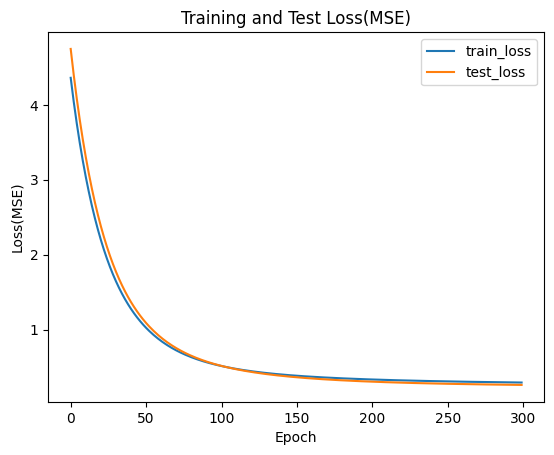

In [ ]:
def train_network():

  (x_train, y_train), (x_test, y_test) = load_data()

  # linear network
  # plot training and test loss over time in jupyter notebook

  shapes = [x_train.shape[1], 1]

  #print(shapes)

  outputs = ["linear"]
  model = initialize_weights(shapes, outputs)
  #print(model)

  fwd_results = forward(x_train, model)
  #print(fwd_results)
  # what's the alpha you should use?

  alpha = 0.01

  train_loss = []
  test_loss = []
  for i in range(300):
    loss, dweights = backward(y_train, x_train, model, "mse")
    update(model, dweights, alpha)
    print(i, loss)
    train_loss.append(loss)
    test_loss.append(mse(y_test, predict(x_test, model)))

  x = [i for i in range(300)]
  plt.plot(x, train_loss, label="train_loss")
  plt.plot(x, test_loss, label="test_loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss(MSE)")
  plt.title("Training and Test Loss(MSE)")
  plt.legend()
  plt.show()

train_network()


- Change training function to collect training and test loss

# 2. Classification on Iris Dataset

In [ ]:
def load_iris():
  iris = datasets.load_iris()
  x = iris.data.astype(np.float32)
  y = iris.target

  y = to_categorical(y, np.max(y)+1).astype(np.float32)

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
  # (B,) -> {0, 1, 2}
  # (B, 3) -> 0 -> y[:, 0] = 1, 1 -> y[:, 1] = 1

  # need to do conditioning on the dataset
  x_train = standardize(x_train)
  x_test = standardize(x_test)

  print(f"X_train shape: {x_train.shape}, Y_train shape: {y_train.shape}")
  print(f"X_test shape: {x_test.shape}, Y_test shape: {y_test.shape}")

  return (x_train, y_train), (x_test, y_test)

X_train shape: (120, 4), Y_train shape: (120, 3)
X_test shape: (30, 4), Y_test shape: (30, 3)
0 1.3821274583555847
1 0.462127950367015
2 0.37414144431460067
3 0.34243148808959634
4 0.31963664627725125
5 0.3020993562940797
6 0.28796663583107857
7 0.27629613327879565
8 0.2661207688931394
9 0.2573157905318849
10 0.24930768391523764
11 0.24225057989006293
12 0.23587751561222256
13 0.22986612800972955
14 0.22425512073297554
15 0.21891357747723966
16 0.2136823610396889
17 0.20863266891930546
18 0.20391892787723978
19 0.1995139277116254
20 0.19537545481468116
21 0.1913775926500343
22 0.1874317229371327
23 0.18337662158813653
24 0.17954839305330247
25 0.1758365632262824
26 0.17232471893251347
27 0.1689201098355889
28 0.16544554214356694
29 0.16183249679557934
30 0.15840616107406139
31 0.15524373733923358
32 0.15220713840934774
33 0.1492591046192208
34 0.14643424107573205
35 0.14378677768097503
36 0.14130962833071026
37 0.13891946583003442
38 0.13660478704067605
39 0.13419503848572314
40 0.1317

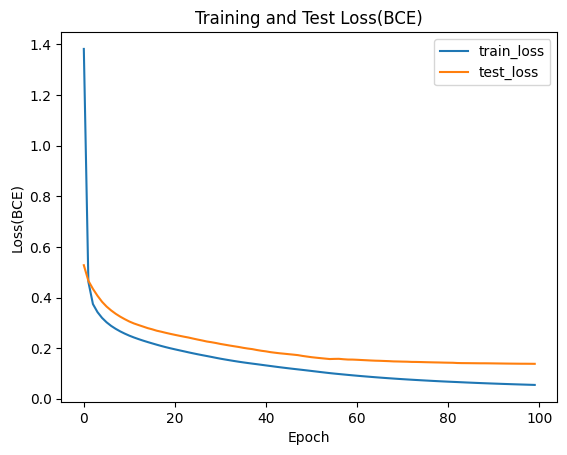

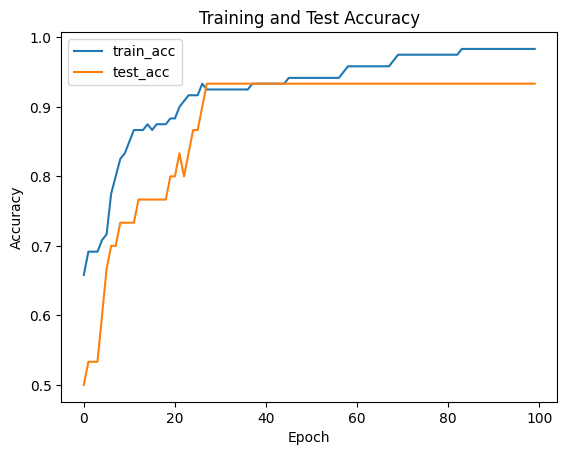

In [ ]:
def accuracy(y, p): # (B, 3)
    # y = (1, 0, 0), p = (0.2, 0.5, 0.3)
    # y = 0, p = 1
    return np.mean(np.argmax(y, axis=-1) == np.argmax(p, axis=-1))

def train_network():
  (x_train, y_train), (x_test, y_test) = load_iris()

  # example of network. try your own to get higher accuracy
  # plot training and test loss over time in jupyter notebook
  # plot training and test accuracy over time in jupyter notebook

  outputs = ["relu", "relu", "sigmoid"]
  shapes = [x_train.shape[1], 30, 10, y_train.shape[1]]

  #print(shapes)

  # which alpha should you use?

  alpha = 0.001
  model = initialize_weights(shapes, outputs)

  train_loss = []
  test_loss = []
  train_acc = []
  test_acc = []
  for i in range(100):
    loss, dweights = backward(y_train, x_train, model, "binary_crossentropy")
    update(model, dweights, alpha)

    train_loss.append(loss)
    train_acc.append(accuracy(y_train, predict(x_train, model)))
    test_loss.append(binary_crossentropy(y_test, predict(x_test, model)))
    test_acc.append(accuracy(y_test, predict(x_test, model)))
    print(i, loss)

  x = [i for i in range(100)]
  plt.plot(x, train_loss, label="train_loss")
  plt.plot(x, test_loss, label="test_loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss(BCE)")
  plt.title("Training and Test Loss(BCE)")
  plt.legend()
  plt.show()

  plt.plot(x, train_acc, label="train_acc")
  plt.plot(x, test_acc, label="test_acc")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title("Training and Test Accuracy")
  plt.legend()
  plt.show()

train_network()

# 3. Packages These Days Use Automatic Differentiation Like AutoGrad

In [ ]:
import autograd.numpy as np
from autograd import elementwise_grad as grad

In [ ]:
x = np.arange(6).astype(np.float32)
x

array([0., 1., 2., 3., 4., 5.], dtype=float32)

In [ ]:
def f(x):
    return 3.0 * np.power(x, 2) + 5.0 * x - 4.0

In [ ]:
grad_f = grad(f)

In [ ]:
grad_f(x)

array([ 5., 11., 17., 23., 29., 35.], dtype=float32)

In [ ]:
(f(x + 0.01) - f(x - 0.01)) / 0.02

array([ 4.9999833, 11.000013 , 17.000008 , 22.999954 , 29.000473 ,
       35.001373 ], dtype=float32)

Comments:

1. I said in the class to always check the shapes to see the operations. dw and w have transposed shapes.
2. If you look at the notes, you will see that y's and z's have the same shape
3. If you need to debug on the fly, put the following line in the code. You can search on the web but basically, you can do step by step computation with pdb.

```python
import pdb; pdb.set_trace()
```